In [1]:
import gym
import numpy as np
import random
from collections import namedtuple, defaultdict

from IPython.display import display, clear_output
from time import sleep

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib import animation
%matplotlib inline

# CartPole-v1

OpenAI's [cartpole problem](https://gym.openai.com/envs/CartPole-v1/):

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

At every time step, you can observe its position (x), velocity (x_dot), angle (theta), and angular velocity (theta_dot). These are the observable states of this world. At any state, the cart only has two possible actions: move to the left or move to the right.

In [78]:
env = gym.make('CartPole-v1')
print(env.action_space, env.observation_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Discrete(2) Box(4,)


In [79]:
env.reset()
env.step(env.action_space.sample())

(array([ 0.03580164,  0.22087061, -0.02961758, -0.32947387]), 1.0, False, {})

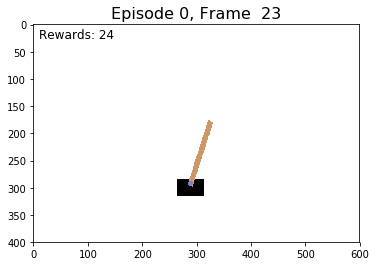

[ 0.00282249 -0.20068576  0.04350225  0.30636185]
[-0.00119122 -0.00620984  0.04962949  0.02770958]
[-0.00131542 -0.20200709  0.05018368  0.3356289 ]
[-0.00535556 -0.39780598  0.05689626  0.6437053 ]
[-0.01331168 -0.20352122  0.06977036  0.36946822]


In [341]:
def show_cart(frames, episode=0):
    """shows cartpole inline for jupyterlab"""
    img = plt.imshow(frames[0])
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        img.set_data(frame)
        plt.imshow(frame)
        plt.text(10,25, f"Rewards: {len(frames)}", fontsize=12)
        plt.title(f"Episode {episode}, Frame {i:3}", fontsize=16)
        plt.show()

for ep in range(1):
    env.reset()
    frames = []
    obs = []
    for i in range(5):
        done = False
        while not done:
            observation, reward, done, info = env.step(env.action_space.sample())
            frames.append(env.render(mode='rgb_array'))
            obs.append(observation)
    show_cart(frames)
    [print(ob) for ob in obs[:5]]

I want to get an idea of the observations. I'm discarding position and velocity as that seems less important than the angle and the angular velocity:

0.2659627368137496 -0.265215073010665 3.340131389273293 -3.4657670569800474


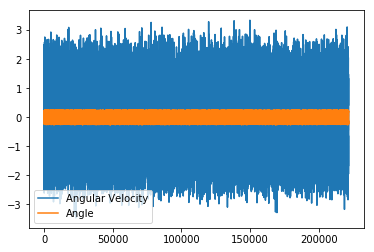

In [294]:
theta = []
theta_dot = []

for i in range(10000):
    env.reset()
    done = False
    while not done:
        observation, reward, done, info = env.step(env.action_space.sample())
        theta.append(observation[2])
        theta_dot.append(observation[3])

print(np.max(theta), np.min(theta), np.max(theta_dot), np.min(theta_dot))
plt.plot(theta_dot, label="Angular Velocity")     
plt.plot(theta, label="Angle")
plt.legend()

Its clear that the the range is pretty small. So I'm going to digitize the bins like so:

In [308]:
theta_bins = np.arange(-0.3,0.4, 0.1)
theta_bins

array([-3.00000000e-01, -2.00000000e-01, -1.00000000e-01,  5.55111512e-17,
        1.00000000e-01,  2.00000000e-01,  3.00000000e-01])

In [307]:
theta_dot_bins = np.arange(-3.8,4.1, 0.5)
theta_dot_bins

array([-3.8, -3.3, -2.8, -2.3, -1.8, -1.3, -0.8, -0.3,  0.2,  0.7,  1.2,
        1.7,  2.2,  2.7,  3.2,  3.7])

In [309]:
def digitize(observation):
    theta = np.digitize(observation[2], bins=theta_bins)
    theta_dot = np.digitize(observation[3], bins=theta_dot_bins)
    return theta, theta_dot

## solving cartpole super simply

First up, I'm just going to consider the angle only, so I can continue using my simple qtable from before

In [310]:
qtable = np.zeros((len(theta_bins), len(theta_dot_bins), env.action_space.n))
qtable.shape

(7, 16, 2)

In [344]:
episodes = 10000
epsilon = 0.7 # our max epsilon value, fix this so it increases slowly
alpha = 0.3  # the learning rate
gamma = 0.89  # the discount rate

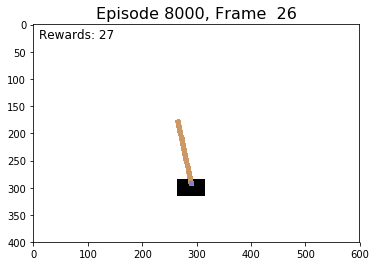

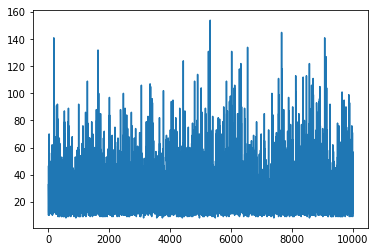

In [345]:
def learn_greedy(episodes=episodes, show=False):
    """moves agent, updates qtable"""
    
    rate = 10 / episodes  # the rate at which to increase epsilon
    reached_goal = 0
    all_rewards = []
    
    for i in range(episodes):
        observation = env.reset()  # reset for each episode
        done = False
        ep = epsilon - epsilon * 1/(1 + rate*i) # grow epsilon from zero to max
        frames = []
        rewards = 0
        
        theta, theta_dot = digitize(observation)
        
        while not done:
            if np.random.random() < ep:
                if np.min(qtable[theta, theta_dot]) == np.max(qtable[theta, theta_dot]):
                    action = env.action_space.sample()
                else:
                    action = np.argmax(qtable[theta, theta_dot])
            else:
                action = env.action_space.sample() # move in a random direction
            
            observation, reward, done, info = env.step(action) # moved the agent
            if show and (i % 2000 == 0):
                frames.append(env.render(mode='rgb_array'))
            rewards += reward
            
            theta_next, theta_dot_next = digitize(observation)
            
            # updating q table
            q = qtable[theta, theta_dot, action]
            max_q = np.max(qtable[theta_next, theta_dot_next])
            qtable[theta, theta_dot, action] = q +  alpha * (reward + gamma * max_q - q)
            
            theta, theta_dot = theta_next, theta_dot_next
        #print(new_state, reward, done, info, action)
        
        all_rewards.append(rewards)
        
        if show and (i % 2000 == 0):
            show_cart(frames, i)
    
    return all_rewards
    
r = learn_greedy(show=True)
plt.plot(r)

In [352]:
def play_greedy(episodes=10, epsilon=0.98, show=False):
    all_rewards = []
    
    for i in range(episodes):
        observation = env.reset()  # reset for each episode
        done = False
        theta, theta_dot = digitize(observation)
        rewards = 0
        frames = []
        
        while not done:
            if np.random.random() < epsilon:
                action = np.argmax(qtable[theta, theta_dot])
            else:
                action = env.action_space.sample() # move in a random direction
            observation, reward, done, info = env.step(action) # moved the agent
            theta, theta_dot = digitize(observation)
            rewards += reward
            
            if show: frames.append(env.render(mode='rgb_array'))
        
        all_rewards.append(rewards)
        if show: show_cart(frames, i)
        
    return all_rewards
    
r = play_greedy(episodes=1, show=True)
print(r)

KeyboardInterrupt: 